In [1]:
# pip install gputools
# pip install scikit-tensor-py3

from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [2]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [3]:
pth=r'\\10.99.68.178\andreex\data\Stardist'
pthtraining= os.path.join(pth,'Training')
pthtesting= os.path.join(pth,'Testing')
pthmodels= os.path.join(pth,'models')
pthfiles= os.path.join(pth,'files')
pthHE= os.path.join(pthtraining,'H&E_tiles')
pthmasks= os.path.join(pthtraining,'Mask_tiles')

In [4]:
training_HE_tiles_pths = sorted(glob(os.path.join(pthHE,'*.tif')))
training_mask_tiles_pths = sorted(glob(os.path.join(pthmasks,'*.tif')))

In [5]:
HE_original_tiles = list(map(imread,training_HE_tiles_pths))
mask_original_tiles = list(map(imread,training_mask_tiles_pths))

In [6]:
def augment_images(HE_tiles, mask_tiles):
  """
  Augments a set of HE images and corresponding mask labels by rotating and flipping them.

  Args:
    HE_tiles: A list of NumPy arrays representing the HE images.
    mask_tiles: A list of NumPy arrays representing the mask labels for the HE images.

  Returns:
    HE_aug: A list of NumPy arrays representing the augmented HE images.
    mask_aug: A list of NumPy arrays representing the augmented mask labels.
  """

  HE_aug = [[] for _ in range(len(HE_tiles))]
  mask_aug = [[] for _ in range(len(mask_tiles))]

  for i in range(len(HE_tiles)):
    im = Image.fromarray(HE_tiles[i])
    lbl = Image.fromarray(mask_tiles[i])

    # Rotate the image and label 90 degrees three times.
    for _ in range(3):
      im = im.rotate(90)
      HE_aug[i].append(im)
      lbl = lbl.rotate(90)
      mask_aug[i].append(lbl)

    # Flip the image and label horizontally.
    im = Image.fromarray(HE_tiles[i])
    flipped_im = im.transpose(Image.FLIP_LEFT_RIGHT)

    lbl = Image.fromarray(mask_tiles[i])
    flipped_lbl = lbl.transpose(Image.FLIP_LEFT_RIGHT)

    HE_aug[i].append(flipped_im)
    mask_aug[i].append(flipped_lbl)

    # Rotate the flipped image and label 90 degrees three times.
    for _ in range(3):
      flipped_im = flipped_im.rotate(90)
      HE_aug[i].append(flipped_im)
      flipped_lbl = flipped_lbl.rotate(90)
      mask_aug[i].append(flipped_lbl)

  return HE_aug, mask_aug

In [7]:
HE_aug, mask_aug = augment_images(HE_original_tiles, mask_original_tiles)

In [8]:
#Normalize input images and fill holes in masks
HE_original_tiles = [x/255 for x in HE_original_tiles]  # no norm, just divide by 255 to get into (0,1) range
mask_original_tiles = [fill_label_holes(y) for y in mask_original_tiles]  # fills holes in annotations if there are any

In [9]:
def normalize_images(images, masks):
  
  normalized_masks = [[] for i in range(len(masks))]
  normalized_images = [[] for i in range(len(images))]
  
  for i in range(len(masks)):
      masks_list = masks[i]
      images_list = images[i]
      
      for j in range(len(images_list)):
          im = images_list[j]
          im = np.asarray(im)
          im = im/255
          normalized_images[i].append(im)
      
      for j in range(len(masks_list)):
          im = masks_list[j]
          im = np.asarray(im)
          im = fill_label_holes(im)
          normalized_masks[i].append(im)
          
  return normalized_images, normalized_masks

In [10]:
HE_aug_norm, mask_aug_norm = normalize_images(HE_aug, mask_aug)

In [11]:
def split_augmented_data(HE_aug_norm_list, mask_aug_norm_list):
  """
  Splits augmented HE images and mask images into training and validation sets.

  Args:
    HE_aug_norm: A list of NumPy arrays representing the normalized augmented HE images.
    mask_aug_norm: A list of NumPy arrays representing the normalized augmented mask images.

  Returns:
    X_trn, Y_trn, X_val, Y_val: Training and validation sets of HE images and mask images.
  """

  # Create empty lists to store the training and validation sets.
  X_trn = []
  Y_trn = []
  X_val = []
  Y_val = []
  
  for i in range(len(HE_aug_norm_list)):
    HE_aug_norm = HE_aug_norm_list[i]
    mask_aug_norm = mask_aug_norm_list[i]
  
    # Assert that there is enough training data.
    assert len(HE_aug_norm) > 1, "not enough training data"
  
    # Create a random number generator with a fixed seed for reproducibility.
    rng = np.random.RandomState(42)
  
    # Permute the indices of the augmented data.
    ind = rng.permutation(len(HE_aug_norm))
  
    # Split the indices into training and validation indices.
    n_val = max(1, int(round(0.15 * len(ind))))
    ind_trn, ind_val = ind[:-n_val], ind[-n_val:]
  
    # Split the augmented data into training and validation sets.
    for kk in ind_trn:
      X_trn.append(HE_aug_norm[kk])
      Y_trn.append(mask_aug_norm[kk])
  
    for lol in ind_val:
      X_val.append(HE_aug_norm[lol])
      Y_val.append(mask_aug_norm[lol])
  
  print(f'number of images: {len(HE_aug_norm_list*len(HE_aug_norm_list[0]))}')
  print(f'- training: {len(X_trn)}')
  print(f'- validation: {len(X_val)}')
  
  X_trn = [np.array(x) for x in X_trn]
  Y_trn = [np.array(y) for y in Y_trn]
  
  X_val = [np.array(x) for x in X_val]
  Y_val = [np.array(y) for y in Y_val]
  
  # Return the training and validation sets.
  return X_trn, Y_trn, X_val, Y_val

In [12]:
HE_trn, mask_trn, HE_val, mask_val = split_augmented_data(HE_aug_norm, mask_aug_norm)

number of images: 77
- training: 66
- validation: 11


In [13]:
#PLot image and label for some images - sanity check
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16/2, 8/2))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

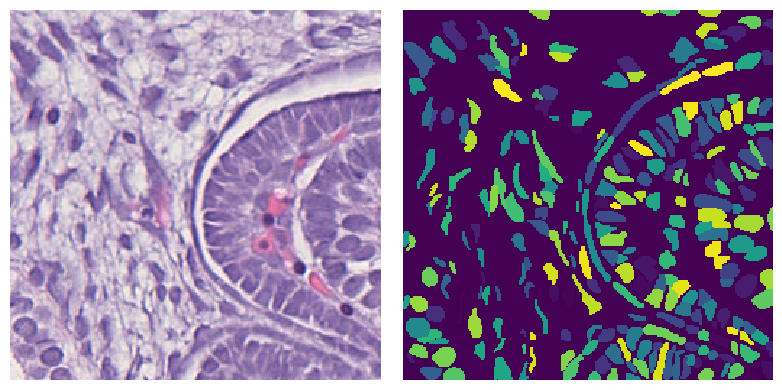

In [15]:
i = 10

img, lbl = HE_val[i], mask_val[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
show_tile_segmented(img,lbl)

In [16]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")
    
print(tf.__version__)

#Define the config by setting some parameter values
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

n_channel = 1 if HE_trn[0].ndim == 2 else HE_trn[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.


conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
# print(conf)
vars(conf)

GPU is available
2.10.1
If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [37]:
#Start from 40x H&E pre-trained model to the specified directory
import copy
import json

def load_justin_model(folder_to_write_new_model_folder: str, name_for_new_model: str) -> StarDist2D:
    published_model = load_model(r'\\10.99.68.178\andreex\students\Donald Monkey fetus\stardist\Model_00')
    original_thresholds = copy.copy({'prob': published_model.thresholds[0], 'nms': published_model.thresholds[1]})
    configuration = Config2D(n_channel_in=3, grid=(2,2), use_gpu=True, train_patch_size=[256, 256])
    model = StarDist2D(config=configuration, basedir=folder_to_write_new_model_folder, name=name_for_new_model)
    model.keras_model.set_weights(published_model.keras_model.get_weights())
    model.thresholds = original_thresholds
    return model

def load_published_he_model(folder_to_write_new_model_folder: str, name_for_new_model: str) -> StarDist2D:
    published_model = StarDist2D.from_pretrained('2D_versatile_he')
    original_thresholds = copy.copy({'prob': published_model.thresholds[0], 'nms': published_model.thresholds[1]})
    configuration = Config2D(n_channel_in=3, grid=(2,2), use_gpu=True, train_patch_size=[256, 256])
    model = StarDist2D(config=configuration, basedir=folder_to_write_new_model_folder, name=name_for_new_model)
    model.keras_model.set_weights(published_model.keras_model.get_weights())
    model.thresholds = original_thresholds
    return model

def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

def configure_model_for_training(model: StarDist2D,
                                 epochs: int = 25, learning_rate: float = 1e-6,
                                 batch_size: int = 4, patch_size: list[int,int] = [256, 256]) -> StarDist2D:
    model.config.train_epochs = epochs
    model.config.train_learning_rate = learning_rate
    model.config.train_batch_size = batch_size
    model.config.train_patch_size = patch_size
    return model

In [38]:
# pth_save = r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist'
# outnm = 'monkey_tile_trained_v5'  # make sure to change!

nm='monkey_fallopian_tube'
dt='_11_02_2023'
lrlbl='_5e-6'
outnm = nm + dt + lrlbl
model = load_published_he_model(pthmodels, outnm)

model.config.train_learning_rate = 5e-6
model.config.train_patch_size = (256,256)
model.config.train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}
print(model.config)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.653768, nms_thresh=0.3.
Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sampl

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\models\monkey_fallopian_tube_11_02_2023_5e-6


In [50]:
# HE_trn, mask_trn, HE_val, mask_val
checkpoint_pth= os.path.join(pthmodels, outnm,'checkpoints\cp.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_pth)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_pth,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
tensorboard --logdir='\\10.99.68.178\andreex\data\Stardist\models\monkey_ft_11_02_2023_lr_1e-4_epochs_200_pt_10\logs\train\'

# download and install node js 
# C:\Program Files\nodejs
# path into environment variables 
# npm install -g npx
# tensorboard --logdir=\\10.99.68.178\andreex\data\Stardist\models\monkey_ft_11_02_2023_lr_5e-5_epochs_200_pt_10\logs\train\ 

In [81]:
import datetime


In [80]:
# model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=10, steps_per_epoch=100, train_learning_rate=10e-6)
model.train(HE_trn, 
            mask_trn,
            validation_data=(HE_val,mask_val),
            epochs=200,
            steps_per_epoch=10)

TypeError: train() got an unexpected keyword argument 'callbacks'

In [ ]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(HE_val, mask_val)

In [24]:
model

StarDist2D(monkey_fallopian_tube_11_02_2023_5e-6): YXC → YXC
├─ Directory: \\10.99.68.178\andreex\data\Stardist\models\monkey_fallopian_tube_11_02_2023_5e-6
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, tra

In [25]:
#Predict on validation images
mask_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(HE_val)]

100%|██████████| 11/11 [00:01<00:00, 10.77it/s]


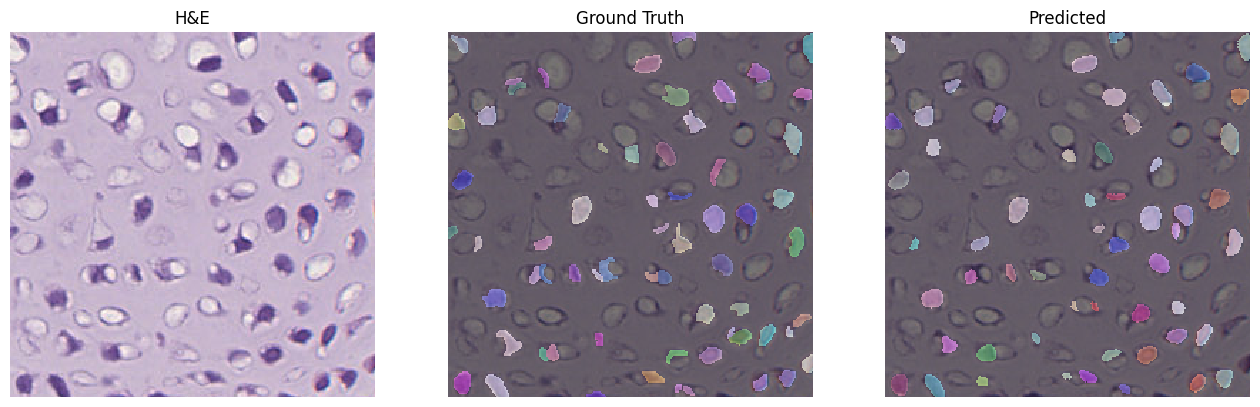

In [31]:
ind = 8

cropped_img = HE_val[ind]
cropped_lbl = mask_val_pred[ind]
cropped_lbl_gt = mask_val[ind]

fig, ax = plt.subplots(1,3,figsize = (16, 8))
ax[0].imshow(cropped_img)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbl_gt, cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Ground Truth')

ax[2].imshow(cropped_img)
ax[2].imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.5)
ax[2].axis('off')
ax[2].set_title('Predicted')
plt.show()

In [41]:
pth_DK_model=r'\\10.99.68.178\andreex\data\Stardist\models\monkey_fallopian_tube11_02_2023_lr_5e-5'
modelDK = load_model(pth_DK_model)

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5, nms=0.4) 


In [42]:
#Optimize the thresolds using the trained model
# modelDK.optimize_thresholds(HE_val, mask_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:03<00:01,  4.19it/s, 0.677 -> 0.622]


Using optimized values: prob_thresh=0.652746, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.652746472359832, 'nms': 0.3}

In [43]:
#Predict on validation images
mask_val_predDK = [modelDK.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(HE_val)]

100%|██████████| 11/11 [00:01<00:00, 10.48it/s]


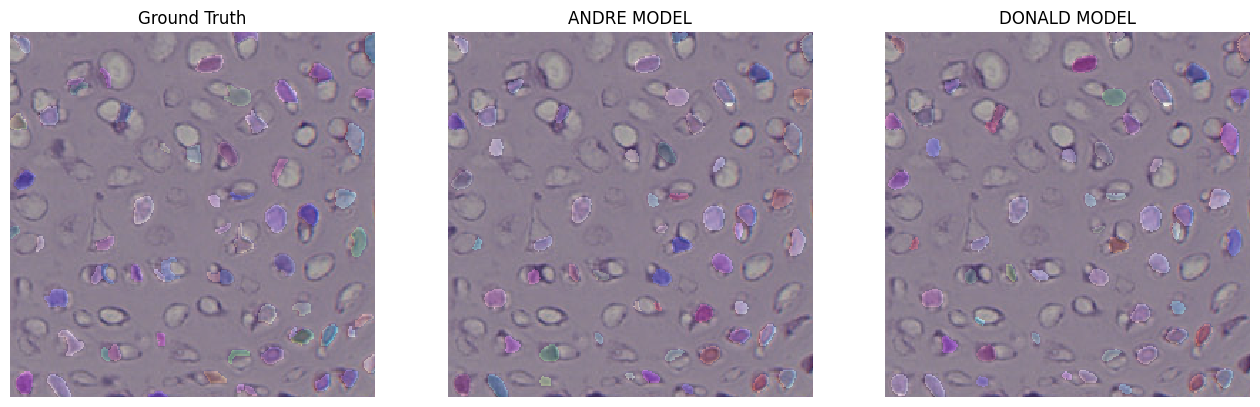

In [47]:
# ind = 8
cropped_lblDK = mask_val_predDK[ind]

fig, ax = plt.subplots(1,3,figsize = (16, 8))
ax[0].imshow(cropped_img)
ax[0].imshow(cropped_lbl_gt, cmap=lbl_cmap, alpha=0.3)
ax[0].axis('off')
ax[0].set_title('Ground Truth')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.3)
ax[1].axis('off')
ax[1].set_title('ANDRE MODEL')

ax[2].imshow(cropped_img)
ax[2].imshow(cropped_lblDK, cmap=lbl_cmap, alpha=0.3)
ax[2].axis('off')
ax[2].set_title('DONALD MODEL')
plt.show()